In [1]:
from argparse import Namespace

from utils.SAMMed2D_segment_anything import sam_model_registry
from classes.SAMMed2DClass import SAMMed2DInferer, SAMMed2DWrapper
from utils.base_classes import Points

import utils.analysisUtils as anUt
import utils.promptUtils as prUt
from utils.imageUtils import read_im_gt

def load_sammed2d(checkpoint_path, device = 'cuda'):
    device = 'cuda'
    args = Namespace()
    args.image_size = 256
    args.encoder_adapter = True
    args.sam_checkpoint = checkpoint_path
    model = sam_model_registry["vit_b"](args).to(device)

    return(model)

# Obtain model, image, gt
device = 'cuda'
checkpoint_path = "/home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth"

model = load_sammed2d(checkpoint_path, device)
sam_wrapper = SAMMed2DWrapper(model, device)
inferer = SAMMed2DInferer(sam_wrapper)

img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'
img, gt = read_im_gt(img_path, gt_path)

# img_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/imagesTs/amos_0001.nii.gz'
# gt_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTs/amos_0001.nii.gz'
# img, gt = read_im_gt_row_major(img_path, gt_path, 2)



True
*******load /home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth


In [2]:
# Experiment: n randomly sampled points from foreground
seed = 11121
n=1
pts_prompt = prUt.get_pos_clicks2D_row_major(gt, n, seed = seed)
segmentation = inferer.predict(img, pts_prompt)
anUt.compute_dice(segmentation, gt)

Performing inference on slices:   0%|          | 0/47 [00:00<?, ?it/s]

Performing inference on slices: 100%|██████████| 47/47 [00:01<00:00, 24.43it/s]


0.648547790881887

In [11]:
# Experiment: Given n equally spaced slices, pick a 'central point' and interpolate a curve (DoF: linear vs cubic) between teh points
n = 5
interpolation = 'linear'
simulated_clicks = prUt.get_fg_points_from_cc_centers(gt, n)
coords = prUt.interpolate_points(simulated_clicks, kind = interpolation)
pts_prompt = Points({'coords': coords, 'labels': [1]*len(coords)})
segmentation = inferer.predict(img, pts_prompt)

anUt.compute_dice(segmentation, gt)

Performing inference on slices:   0%|          | 0/47 [00:00<?, ?it/s]

Performing inference on slices: 100%|██████████| 47/47 [00:01<00:00, 27.32it/s]


0.723732818584218

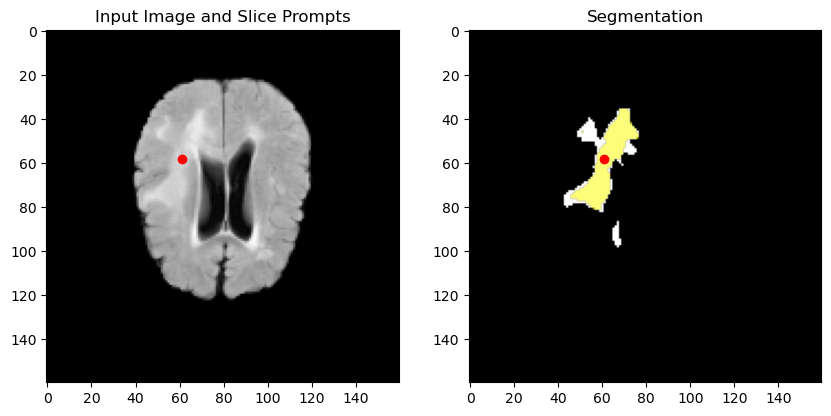

0.8056288478452067

In [4]:
# Visualise segmentation slice-wise
slice_idx = 60
anUt.show_seg_row_major(slice_idx, img, gt, segmentation, pts_prompt = pts_prompt)